In [1]:
import pandas as pd

base_dir = "/kaggle/input/nutrition5k-dataset"

dish_nutrition = pd.read_csv(f"{base_dir}/dish_nutrition_values.csv")
dish_ingredients = pd.read_csv(f"{base_dir}/dish_ingredients.csv")
ingredient_meta = pd.read_csv(f"{base_dir}/ingredients_metadata.csv")

print("Dish Nutrition:")
print(dish_nutrition.head())

print("\nDish Ingredients:")
print(dish_ingredients.head())

print("\nIngredient Metadata:")
print(ingredient_meta.head())


Dish Nutrition:
           dish_id    calories   mass        fat       carb    protein
0  dish_1561662216  300.794281  193.0  12.387489  28.218290  18.633970
1  dish_1562688426  137.569992   88.0   8.256000   5.190000  10.297000
2  dish_1561662054  419.438782  292.0  23.838249  26.351543  25.910593
3  dish_1562008979  382.936646  290.0  22.224644  10.173570  35.345387
4  dish_1560455030   20.590000  103.0   0.148000   4.625000   0.956000

Dish Ingredients:
           dish_id          ingr_id   ingr_name     grams   calories  \
0  dish_1561662216  ingr_0000000508   soy sauce  3.398568   1.801241   
1  dish_1561662216  ingr_0000000122      garlic  2.124105   3.164916   
2  dish_1561662216  ingr_0000000026  white rice  8.496420  11.045346   
3  dish_1561662216  ingr_0000000524     parsley  0.213397   0.079170   
4  dish_1561662216  ingr_0000000094      onions  1.707173   0.682869   

        fat      carb   protein  
0  0.020391  0.166530  0.275284  
1  0.010621  0.700955  0.135943  
2  0

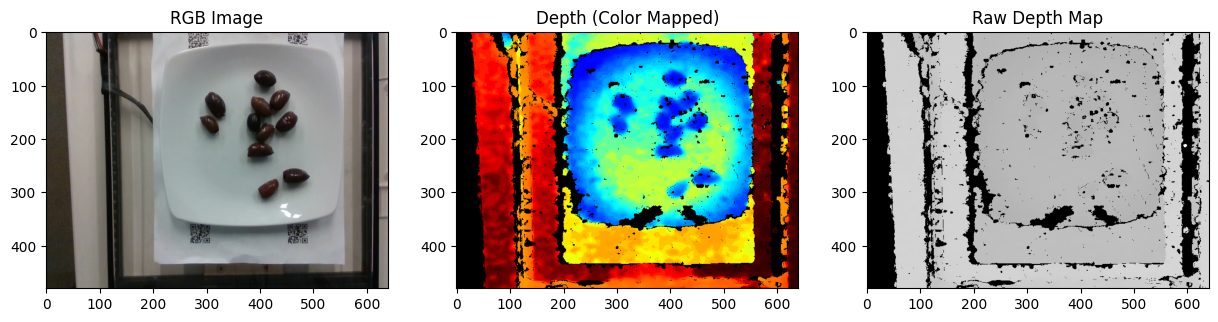

In [2]:
import os
import cv2
import matplotlib.pyplot as plt

base_dir = "/kaggle/input/nutrition5k-dataset/imagery/realsense_overhead"

dish_id = "dish_1556572657"
rgb_path = os.path.join(base_dir, dish_id, "rgb.png")
depth_color_path = os.path.join(base_dir, dish_id, "depth_color.png")
depth_raw_path = os.path.join(base_dir, dish_id, "depth_raw.png")

rgb = cv2.cvtColor(cv2.imread(rgb_path), cv2.COLOR_BGR2RGB)
depth_color = cv2.cvtColor(cv2.imread(depth_color_path), cv2.COLOR_BGR2RGB)
depth_raw = cv2.imread(depth_raw_path, cv2.IMREAD_UNCHANGED)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(rgb)
axes[0].set_title("RGB Image")
axes[1].imshow(depth_color)
axes[1].set_title("Depth (Color Mapped)")
axes[2].imshow(depth_raw, cmap="gray")
axes[2].set_title("Raw Depth Map")
plt.show()


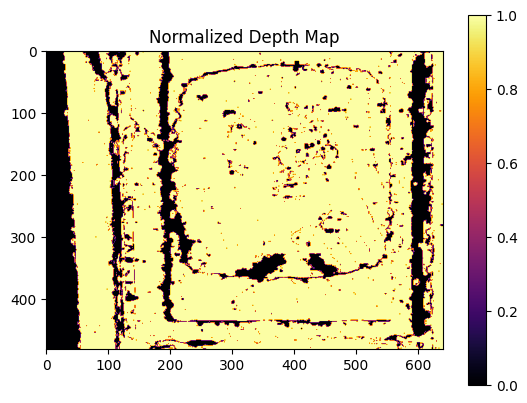

Estimated relative volume: 80.53


In [3]:
import numpy as np

# Normalize depth values
depth_norm = cv2.normalize(depth_raw, None, 0, 1, cv2.NORM_MINMAX)
plt.imshow(depth_norm, cmap='inferno')
plt.title('Normalized Depth Map')
plt.colorbar()
plt.show()

# Simple pseudo-volume calculation (mean depth)
volume_estimate = np.mean(depth_norm) * 100  # arbitrary scaling
print(f"Estimated relative volume: {volume_estimate:.2f}")


In [4]:
import pandas as pd

base_dir = "/kaggle/input/nutrition5k-dataset"
dish_nutrition = pd.read_csv(f"{base_dir}/dish_nutrition_values.csv")

print("Shape:", dish_nutrition.shape)
print("Columns:", dish_nutrition.columns)
dish_nutrition.head()


Shape: (4768, 6)
Columns: Index(['dish_id', 'calories', 'mass', 'fat', 'carb', 'protein'], dtype='object')


dish_id    calories   mass        fat       carb    protein
0  dish_1561662216  300.794281  193.0  12.387489  28.218290  18.633970
1  dish_1562688426  137.569992   88.0   8.256000   5.190000  10.297000
2  dish_1561662054  419.438782  292.0  23.838249  26.351543  25.910593
3  dish_1562008979  382.936646  290.0  22.224644  10.173570  35.345387
4  dish_1560455030   20.590000  103.0   0.148000   4.625000   0.956000

In [5]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

2025-10-18 08:56:08.040043: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760777768.548097      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760777768.689307      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
df = pd.read_csv("/kaggle/input/nutrition5k-dataset/dish_nutrition_values.csv")
print(df.shape)
print(df.head())


(4768, 6)
           dish_id    calories   mass        fat       carb    protein
0  dish_1561662216  300.794281  193.0  12.387489  28.218290  18.633970
1  dish_1562688426  137.569992   88.0   8.256000   5.190000  10.297000
2  dish_1561662054  419.438782  292.0  23.838249  26.351543  25.910593
3  dish_1562008979  382.936646  290.0  22.224644  10.173570  35.345387
4  dish_1560455030   20.590000  103.0   0.148000   4.625000   0.956000


In [7]:
import os


image_root = f"{base_dir}/imagery/realsense_overhead"

# Create full image path for each dish
dish_nutrition["rgb_path"] = dish_nutrition["dish_id"].apply(
    lambda x: os.path.join(image_root, x, "rgb.png")
)

# Check if the image actually exists
dish_nutrition["image_exists"] = dish_nutrition["rgb_path"].apply(os.path.exists)

# Filter only valid ones
valid_dishes = dish_nutrition[dish_nutrition["image_exists"] == True]

print("✅ Total valid dishes with images:", len(valid_dishes))
valid_dishes.head()


✅ Total valid dishes with images: 3244


dish_id    calories   mass        fat       carb    protein  \
0  dish_1561662216  300.794281  193.0  12.387489  28.218290  18.633970   
2  dish_1561662054  419.438782  292.0  23.838249  26.351543  25.910593   
3  dish_1562008979  382.936646  290.0  22.224644  10.173570  35.345387   
4  dish_1560455030   20.590000  103.0   0.148000   4.625000   0.956000   
5  dish_1558372433   74.360001  143.0   0.286000   0.429000  20.020000   

                                            rgb_path  image_exists  
0  /kaggle/input/nutrition5k-dataset/imagery/real...          True  
2  /kaggle/input/nutrition5k-dataset/imagery/real...          True  
3  /kaggle/input/nutrition5k-dataset/imagery/real...          True  
4  /kaggle/input/nutrition5k-dataset/imagery/real...          True  
5  /kaggle/input/nutrition5k-dataset/imagery/real...          True

In [8]:
print(valid_dishes.columns)

Index(['dish_id', 'calories', 'mass', 'fat', 'carb', 'protein', 'rgb_path',
       'image_exists'],
      dtype='object')


In [9]:
import cv2
import numpy as np

IMG_SIZE = (224, 224)

def load_image(path):
    img = cv2.imread(path)
    if img is None:
        return np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3))  # placeholder for missing images
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0
    return img

# Only use rows where image exists
valid_dishes = valid_dishes[valid_dishes['image_exists'] == True]

# Load images
valid_dishes['image_array'] = valid_dishes['rgb_path'].apply(load_image)

# Convert to numpy array for training
X = np.stack(valid_dishes['image_array'].values)
y = valid_dishes[['calories', 'fat', 'carb', 'protein']].values


In [10]:
X = np.stack(valid_dishes['image_array'].values)  # shape: (num_samples, 224, 224, 3)
y = valid_dishes[['calories', 'fat', 'carb', 'protein']].values  # shape: (num_samples, 4)

print(X.shape, y.shape)


(3244, 224, 224, 3) (3244, 4)


In [11]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input

# Assuming input images are 224x224x3
input_shape = (224, 224, 3)
num_nutrients = 4  # calories, fat, carb, protein

# Base model without top
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

# Add custom head
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(num_nutrients, activation='linear')(x)  # Regression for nutrients

model = Model(inputs=base_model.input, outputs=outputs)

# Compile
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Show summary
model.summary()


I0000 00:00:1760777888.424380      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760777888.425194      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 126,353,284 (482.00 MB)

 Trainable params: 126,300,164 (481.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # monitor validation loss
    factor=0.5,            # reduce LR by half
    patience=3,            # wait 3 epochs before reducing
    min_lr=1e-6,           # lower bound for learning rate
    verbose=1
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[reduce_lr]  # include ReduceLROnPlateau
)


Epoch 1/50


I0000 00:00:1760777946.345373     107 service.cc:148] XLA service 0x793d680bc3e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760777946.347093     107 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760777946.347125     107 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760777951.087381     107 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1760777972.666274     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


82/82 ━━━━━━━━━━━━━━━━━━━━ 128s 655ms/step - loss: 12775.1738 - mae: 49.7880 - val_loss: 13471.7871 - val_mae: 55.9928 - learning_rate: 0.0010
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 326ms/step - loss: 4158.0625 - mae: 28.3339 - val_loss: 28697.2520 - val_mae: 77.9442 - learning_rate: 0.0010
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 28s 340ms/step - loss: 3935.7366 - mae: 27.0404 - val_loss: 27524.0410 - val_mae: 75.2760 - learning_rate: 0.0010
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 7025.5684 - mae: 29.6855
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 331ms/step - loss: 6988.0337 - mae: 29.6474 - val_loss: 28449.7227 - val_mae: 77.8845 - learning_rate: 0.0010
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 330ms/step - loss: 2364.3411 - mae: 19.6663 - val_loss: 28665.8340 - val_mae: 78.0982 - learning_rate: 5.0000e-04
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 333ms/step - loss: 1363.3947 - mae: 18.6741 - val_los

In [14]:
from sklearn.metrics import mean_absolute_error

y_pred = model.predict(X_test)
nutrients = ['calories', 'fat', 'carb', 'protein']

for i, nutrient in enumerate(nutrients):
    mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
    print(f"{nutrient} MAE: {mae:.2f}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 283ms/step
calories MAE: 60.98
fat MAE: 4.91
carb MAE: 7.91
protein MAE: 6.95


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


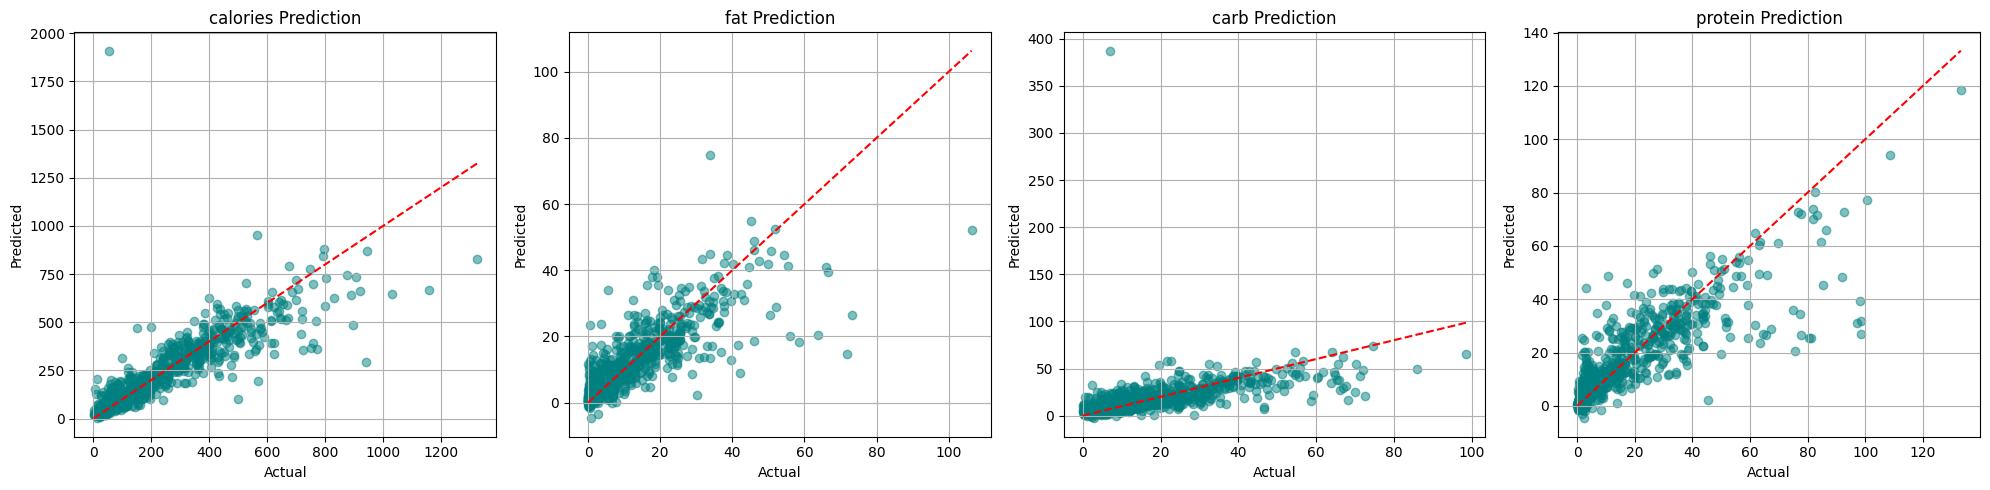

In [15]:
import matplotlib.pyplot as plt
import numpy as np

nutrients = ['calories', 'fat', 'carb', 'protein']

# Predict on test set
y_pred = model.predict(X_test)

# Plot predicted vs actual for each nutrient
plt.figure(figsize=(20, 5))

for i, nutrient in enumerate(nutrients):
    plt.subplot(1, 4, i+1)
    plt.scatter(y_test[:, i], y_pred[:, i], alpha=0.5, color='teal')
    plt.plot([y_test[:, i].min(), y_test[:, i].max()],
             [y_test[:, i].min(), y_test[:, i].max()],
             color='red', linestyle='--')  # perfect prediction line
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{nutrient} Prediction')
    plt.grid(True)

plt.tight_layout()
plt.show()


In [16]:
from sklearn.model_selection import train_test_split

# Split using positional indices
pos_indices = np.arange(len(X))  # 0, 1, 2, ..., 3243
train_idx, test_idx = train_test_split(pos_indices, test_size=0.2, random_state=42)

# Split arrays
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]


In [17]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Prepare DataFrame for hover info
plot_df = pd.DataFrame({
    'dish_id': valid_dishes.iloc[test_idx]['dish_id'].values,
    'actual_calories': y_test[:, 0],
    'predicted_calories': y_pred[:, 0],
    'actual_fat': y_test[:, 1],
    'predicted_fat': y_pred[:, 1],
    'actual_carb': y_test[:, 2],
    'predicted_carb': y_pred[:, 2],
    'actual_protein': y_test[:, 3],
    'predicted_protein': y_pred[:, 3],
})

nutrients = ['calories', 'fat', 'carb', 'protein']

# Create subplots
fig = make_subplots(rows=1, cols=4, subplot_titles=[n.capitalize() for n in nutrients])

for i, nutrient in enumerate(nutrients):
    fig.add_trace(
        go.Scatter(
            x=plot_df[f'actual_{nutrient}'],
            y=plot_df[f'predicted_{nutrient}'],
            mode='markers',
            marker=dict(color='teal', size=6, opacity=0.6),
            text=plot_df['dish_id'],  # hover info
            name=nutrient
        ),
        row=1,
        col=i+1
    )
    # Add perfect prediction line
    min_val = plot_df[f'actual_{nutrient}'].min()
    max_val = plot_df[f'actual_{nutrient}'].max()
    fig.add_trace(
        go.Scatter(
            x=[min_val, max_val],
            y=[min_val, max_val],
            mode='lines',
            line=dict(color='red', dash='dash'),
            showlegend=False
        ),
        row=1,
        col=i+1
    )

fig.update_layout(
    height=500,
    width=1800,
    title_text="Predicted vs Actual Nutrients (hover shows dish_id)"
)

fig.show()


In [18]:
!pip install ipywidgets

In [19]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

# Function to display image and nutrients
def show_dish(idx):
    img = X_test[idx]
    pred_nutrients = y_pred[idx]
    mass = valid_dishes.iloc[test_idx[idx]]['mass']
    dish_id = valid_dishes.iloc[test_idx[idx]]['dish_id']
    
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Dish ID: {dish_id}')
    plt.show()
    
    print(f"Predicted nutrients for {mass} g of food:")
    print(f"Calories: {pred_nutrients[0]:.2f} kcal")
    print(f"Fat: {pred_nutrients[1]:.2f} g")
    print(f"Carbohydrates: {pred_nutrients[2]:.2f} g")
    print(f"Protein: {pred_nutrients[3]:.2f} g")

# Slider widget
dish_slider = widgets.IntSlider(
    min=0,
    max=len(X_test)-1,
    step=1,
    description='Dish Index:',
    continuous_update=False
)

# Link slider to function
widgets.interact(show_dish, idx=dish_slider)


interactive(children=(IntSlider(value=0, continuous_update=False, description='Dish Index:', max=648), Output(…

<function __main__.show_dish(idx)>

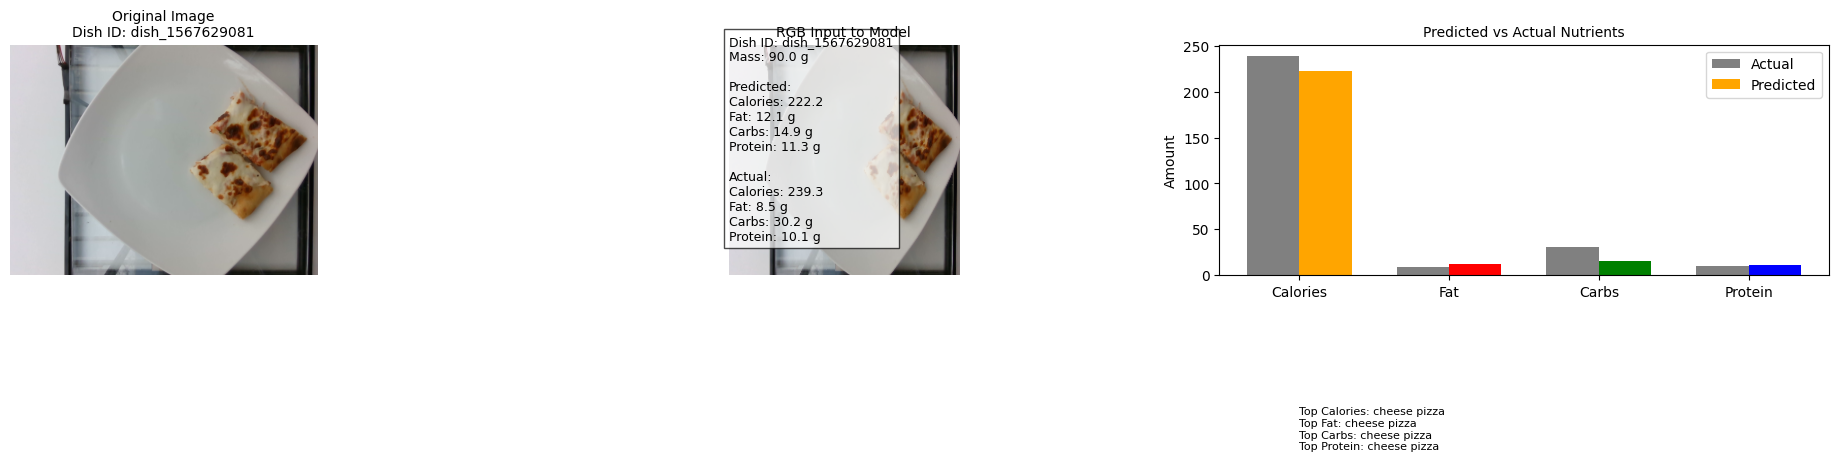

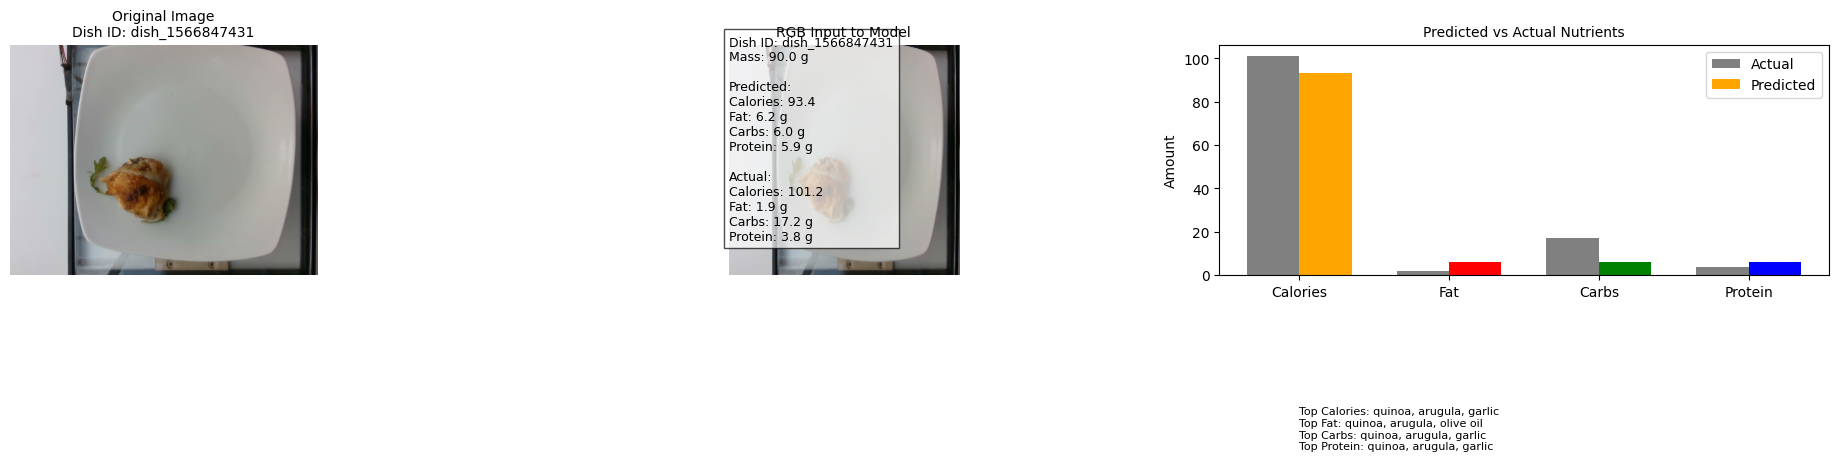

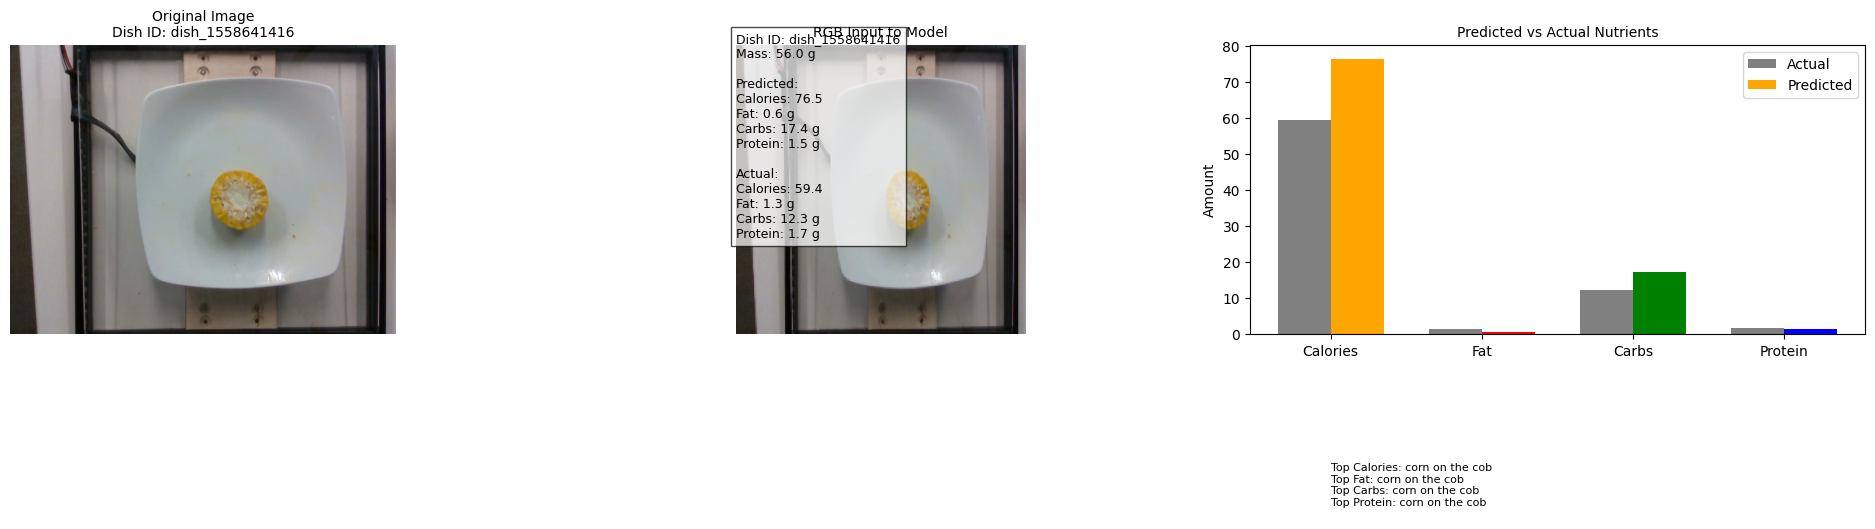

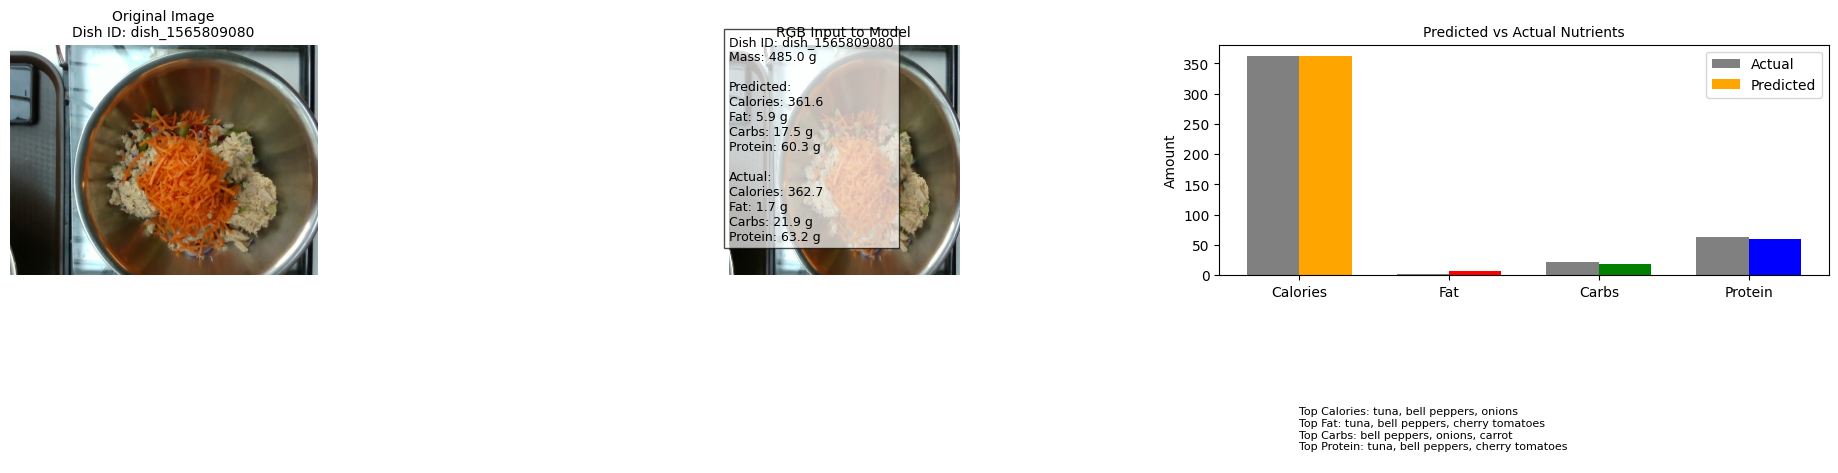

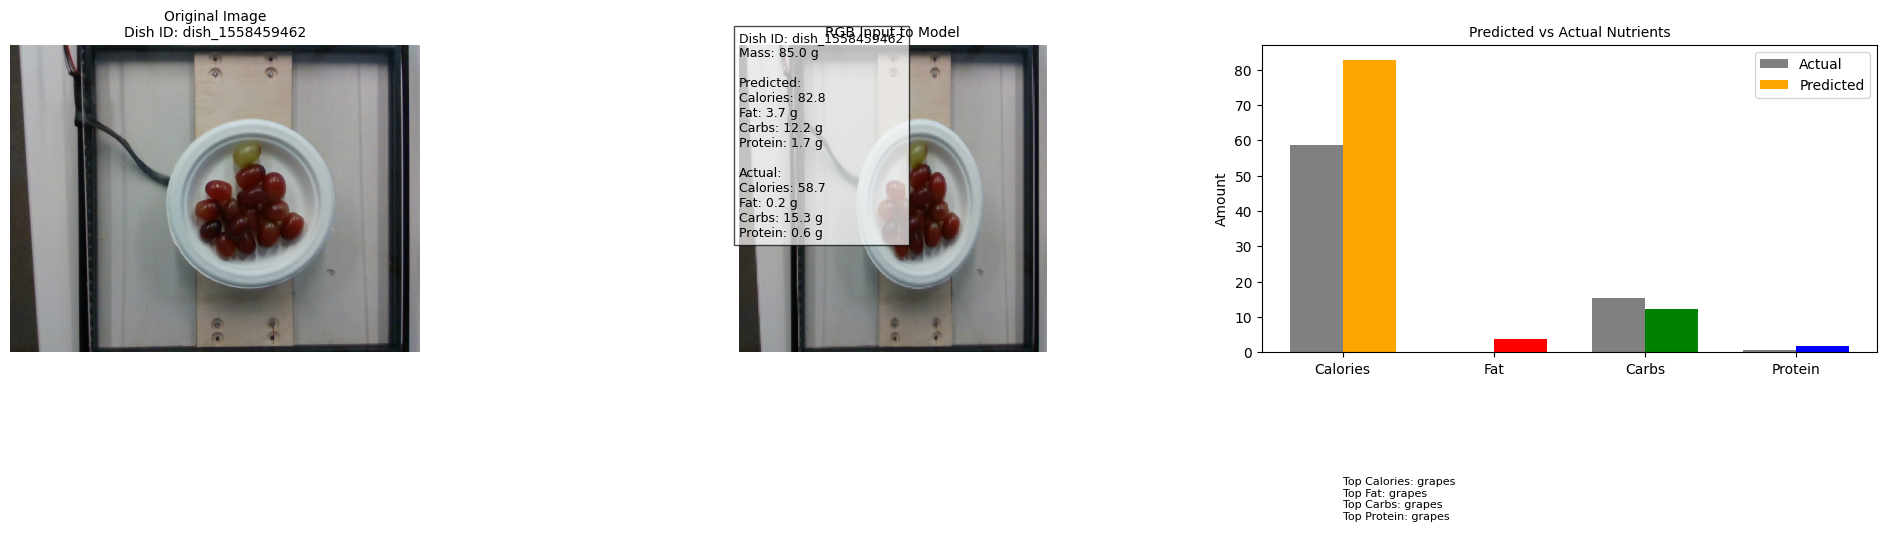

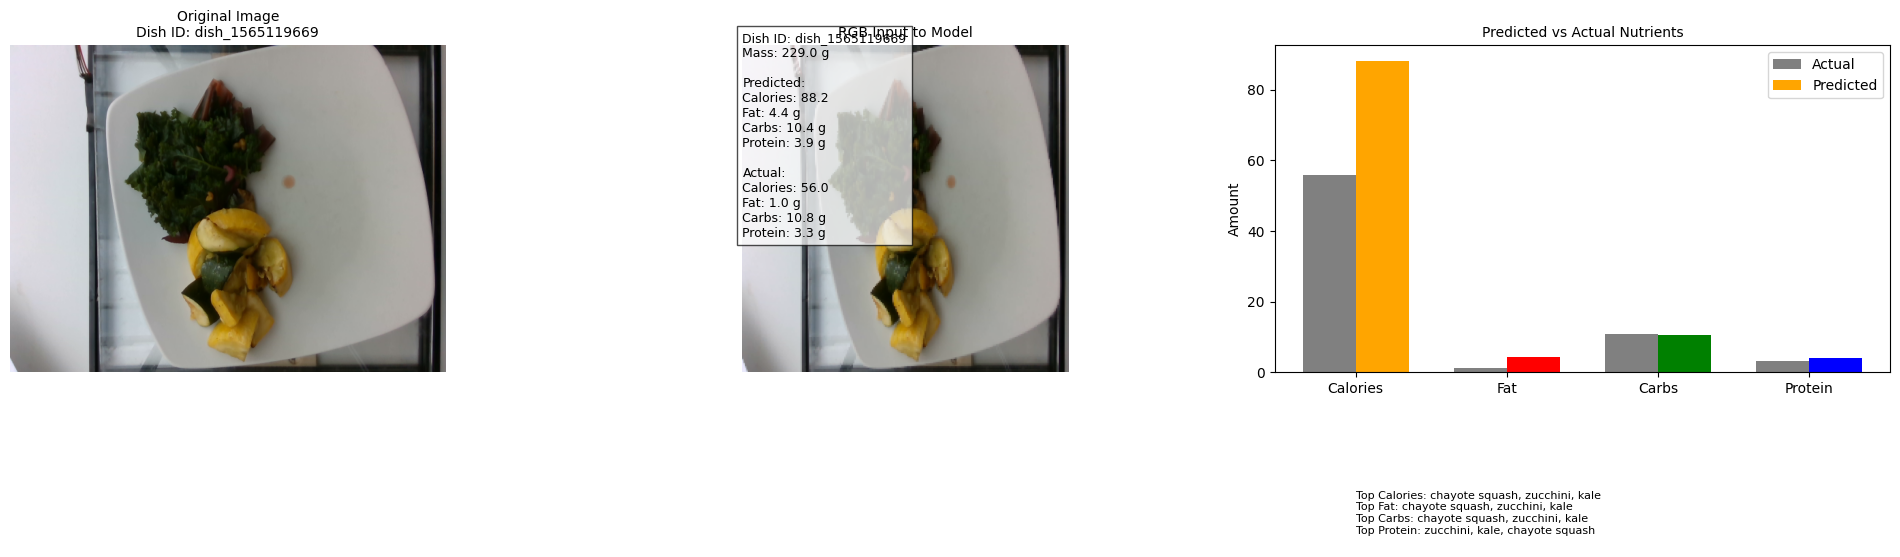

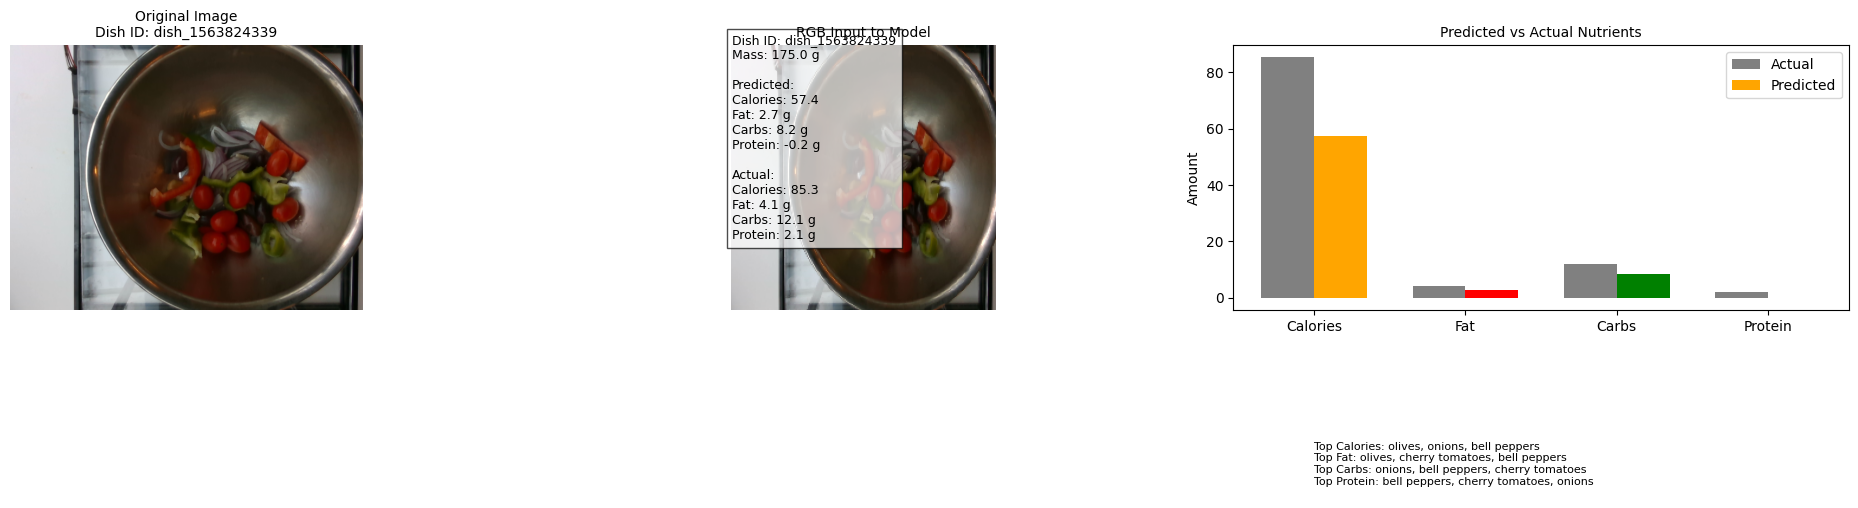

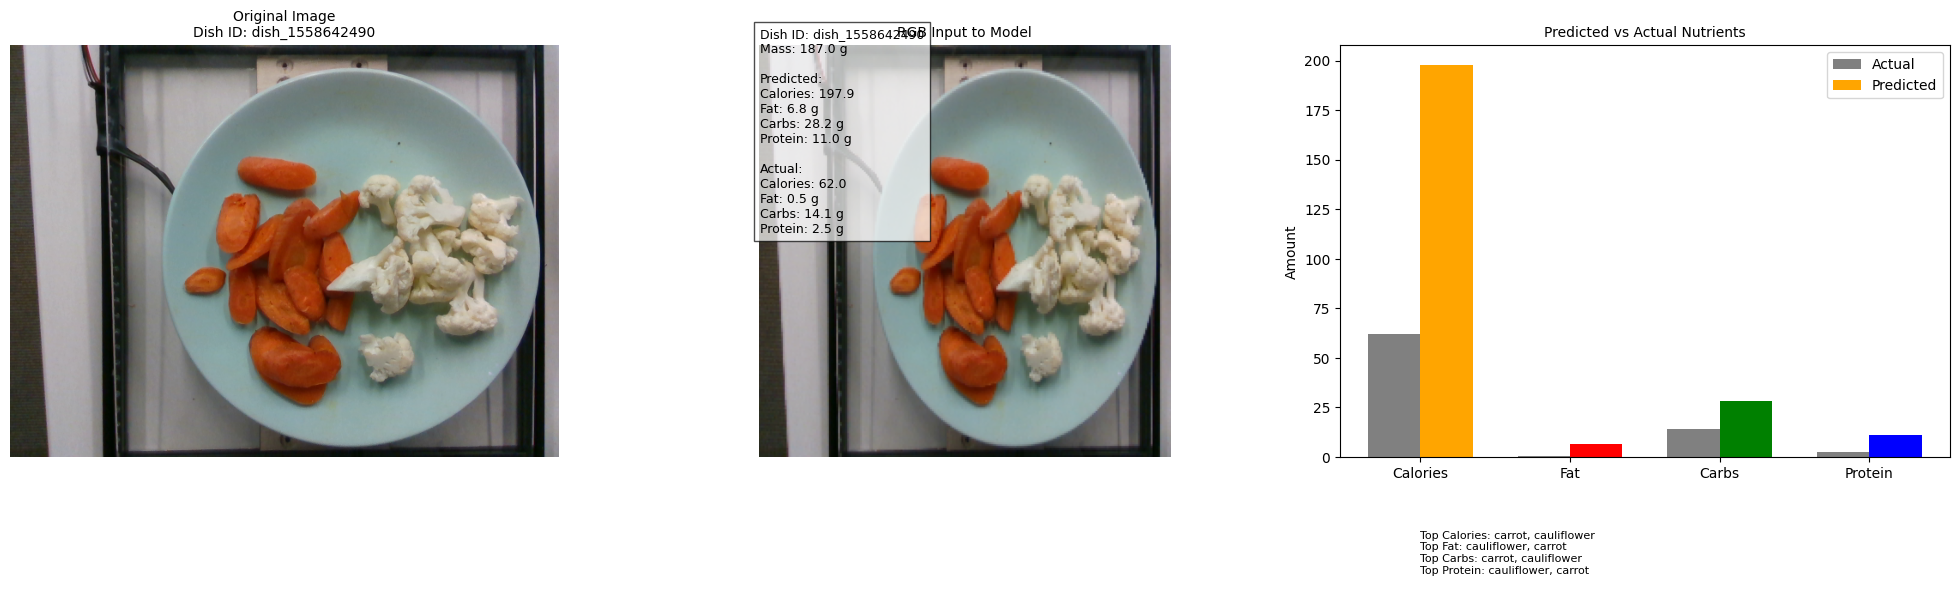

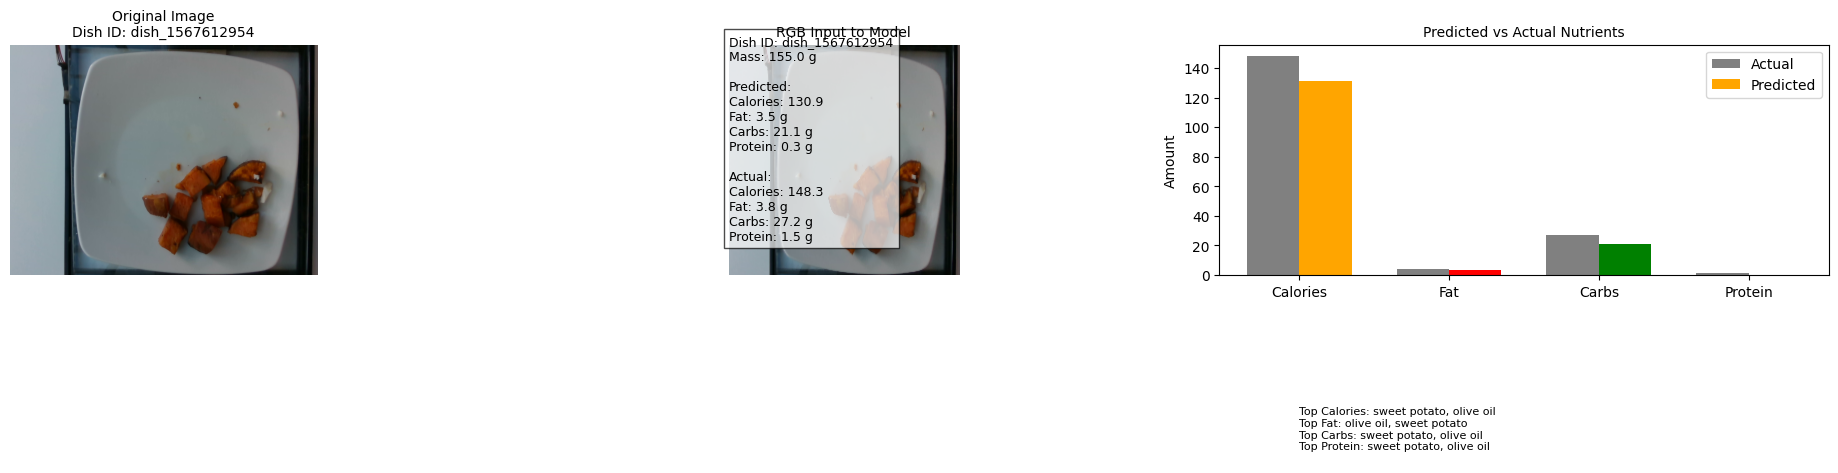

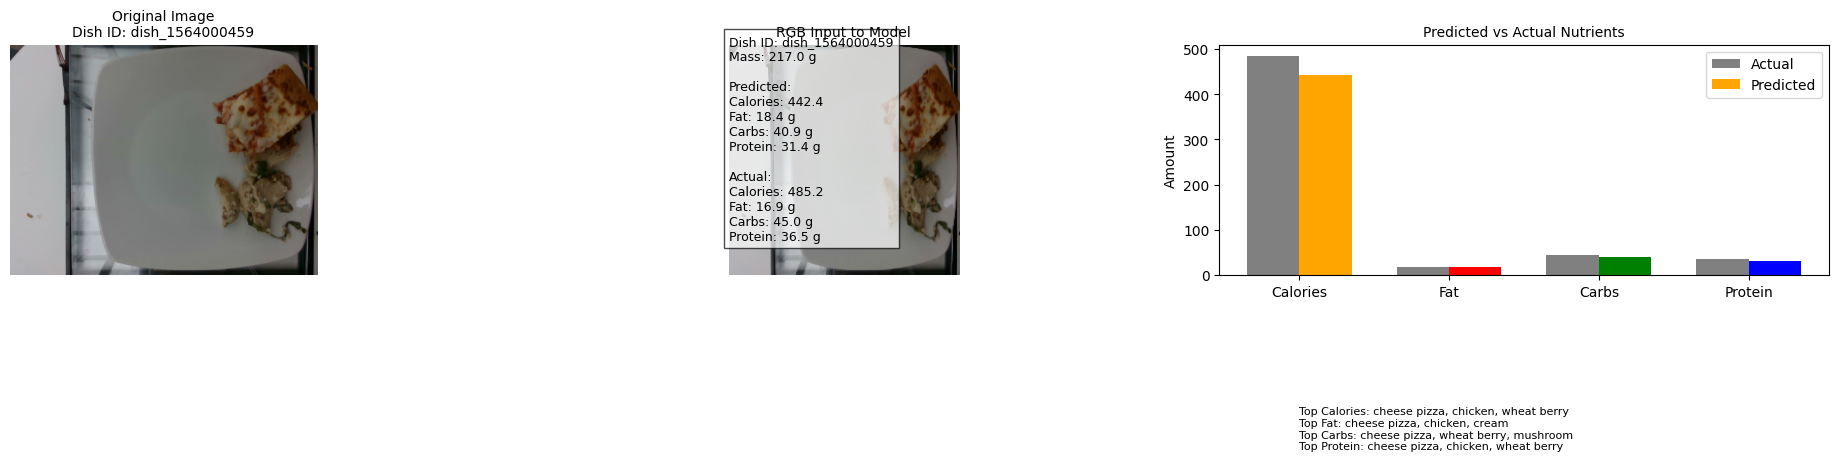

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

num_examples = 10
example_indices = np.random.choice(len(X_test), num_examples, replace=False)

nutrients = ['Calories', 'Fat', 'Carbs', 'Protein']

for i, idx in enumerate(example_indices):
    # Dish info
    dish_id = valid_dishes.iloc[test_idx[idx]]['dish_id']
    mass = valid_dishes.iloc[test_idx[idx]]['mass']
    pred_nutrients = y_pred[idx]
    actual_nutrients = y_test[idx]

    # Images
    original_img = plt.imread(valid_dishes.iloc[test_idx[idx]]['rgb_path'])
    rgb_img = (X_test[idx] * 255).astype(np.uint8)

    # Ingredients for this dish
    dish_ingrs = dish_ingredients[dish_ingredients['dish_id'] == dish_id].copy()
    dish_ingrs['calories_contrib'] = dish_ingrs['grams'] * dish_ingrs['calories']
    dish_ingrs['fat_contrib'] = dish_ingrs['grams'] * dish_ingrs['fat']
    dish_ingrs['carb_contrib'] = dish_ingrs['grams'] * dish_ingrs['carb']
    dish_ingrs['protein_contrib'] = dish_ingrs['grams'] * dish_ingrs['protein']

    # Grid: 3 columns (Original | RGB with overlay | Bar chart)
    fig, axes = plt.subplots(1, 3, figsize=(20,6))

    # 1️⃣ Original image
    axes[0].imshow(original_img)
    axes[0].axis('off')
    axes[0].set_title(f'Original Image\nDish ID: {dish_id}', fontsize=10)

    # 2️⃣ RGB input with overlay info
    axes[1].imshow(rgb_img)
    axes[1].axis('off')
    overlay_text = (f"Dish ID: {dish_id}\nMass: {mass} g\n\n"
                    f"Predicted:\nCalories: {pred_nutrients[0]:.1f}\n"
                    f"Fat: {pred_nutrients[1]:.1f} g\n"
                    f"Carbs: {pred_nutrients[2]:.1f} g\n"
                    f"Protein: {pred_nutrients[3]:.1f} g\n\n"
                    f"Actual:\nCalories: {actual_nutrients[0]:.1f}\n"
                    f"Fat: {actual_nutrients[1]:.1f} g\n"
                    f"Carbs: {actual_nutrients[2]:.1f} g\n"
                    f"Protein: {actual_nutrients[3]:.1f} g")
    axes[1].text(0, -10, overlay_text, fontsize=9, color='black',
                 verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))
    axes[1].set_title('RGB Input to Model', fontsize=10)

    # 3️⃣ Predicted vs Actual nutrients + top ingredients
    x = np.arange(len(nutrients))
    width = 0.35
    axes[2].bar(x - width/2, actual_nutrients, width, label='Actual', color='gray')
    axes[2].bar(x + width/2, pred_nutrients, width, label='Predicted', color=['orange','red','green','blue'])
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(nutrients)
    axes[2].set_ylabel('Amount')
    axes[2].set_title('Predicted vs Actual Nutrients', fontsize=10)
    axes[2].legend()

    # Show top 3 ingredient contributors per nutrient as text
    contrib_text = ""
    for j, nutrient in enumerate(['calories_contrib','fat_contrib','carb_contrib','protein_contrib']):
        top_ingrs = dish_ingrs.sort_values(nutrient, ascending=False).head(3)
        top_list = ", ".join(top_ingrs['ingr_name'].values)
        contrib_text += f"Top {nutrients[j]}: {top_list}\n"
    axes[2].text(0, -0.6*max(actual_nutrients), contrib_text, fontsize=8, color='black', verticalalignment='top')

    plt.tight_layout()
    plt.show()


In [35]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f"Overall MAE: {mae:.2f}")


Overall MAE: 20.19


In [36]:
nutrients = ['calories','fat','carb','protein']
for i, nutrient in enumerate(nutrients):
    mae_n = mean_absolute_error(y_test[:,i], y_pred[:,i])
    print(f"{nutrient.capitalize()} MAE: {mae_n:.2f}")


Calories MAE: 60.98
Fat MAE: 4.91
Carb MAE: 7.91
Protein MAE: 6.95


# XAI

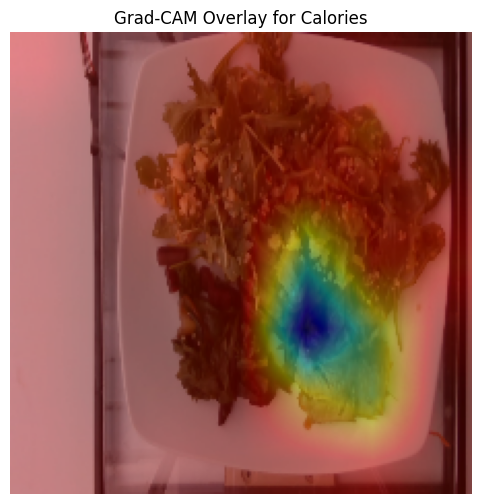

In [40]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Select a test image
idx = 0  # change index to visualize other images
X_sample = X_test[idx]

# Expand dims to batch
X_input = np.expand_dims(X_sample, axis=0)  # shape (1,224,224,3)

# Select last conv layer in your ResNet50
last_conv_layer = model.get_layer("conv5_block3_out")  # adjust layer name if different

# Build Grad-CAM model
grad_model = Model([model.inputs], [last_conv_layer.output, model.output])

# Forward pass with gradient tape
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(X_input)
    # Choose output index: 0=calories, 1=fat, 2=carb, 3=protein
    loss = predictions[:, 0]  # calories example

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
conv_outputs = conv_outputs.numpy()[0]

# Weight conv outputs
for i in range(pooled_grads.shape[-1]):
    conv_outputs[:,:,i] *= pooled_grads[i]

heatmap = np.mean(conv_outputs, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = cv2.resize(heatmap, (224,224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Overlay heatmap on original RGB image
overlayed_img = cv2.addWeighted(np.uint8(X_sample*255), 0.6, heatmap, 0.4, 0)

# Display
plt.figure(figsize=(6,6))
plt.imshow(overlayed_img)
plt.axis('off')
plt.title("Grad-CAM Overlay for Calories")
plt.show()
